# Parameters optimization

In [13]:
import torchvision
from torchvision.transforms import v2
import torch
import os
import sys
import numpy as np 
import lightning as L
import importlib
import shutil
import tempfile
from lightning.pytorch.utilities.model_summary import ModelSummary


# We add the correct path to the system
PATH_SCRIPTS = ["../"]
sys.path.extend(PATH_SCRIPTS)

import gencellpainting as gc

from gencellpainting.utils.datautils import create_dataloaders

We define a temporary folder for optimization and a folder to provide the results

In [14]:
NAME_MODEL = "VAE_hpar_optim"
# Define the data apth into a folder
PATH_DATA = os.path.abspath(os.path.join(os.getcwd(),"..","..","data"))
PATH_OPTIM = os.path.join(PATH_DATA,"optim",NAME_MODEL)
if not os.path.isdir(PATH_OPTIM):
    os.makedirs(PATH_OPTIM)

We first define the transfroms that the images will be subjected to

In [31]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True) # This also set the values of the tensor between 0 and 1
])

In [32]:
PATH_IMAGES = "/mnt/c/Users/alexi/Documents/data/images/cellpainting/cpg0016-jump/data/resized_tensor_128_uint8"

dl_train, dl_val, ds_train, ds_val = create_dataloaders(PATH_IMAGES,transforms,0.8,nmax=3000)

100%|██████████| 600/600 [00:03<00:00, 195.51it/s]


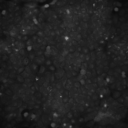

In [58]:
v2.ToPILImage()(ds_train[10][1:2,:,:])

To test the parameters optimization, we simply optimize the parameters of a simple Variaitonal Auto-Encoder

In [17]:
from gencellpainting.model.VAE import VAE

In [18]:
args_to_test = {
    "latent_dim": [256, 512, 1024],
    "network_capacity": [16, 32, 64]
}

args_fixed = {
    "in_channels":5,
    "out_channels":5,
    "epoch_monitoring_interval":-1, # Ensure that no images are saved
    "image_size":128
}

args_trainer = {
    "accelerator":"gpu", "max_epochs":50
}

We can now load the parameters optimizer

In [22]:
import gencellpainting.evaluation.hparams_optimization as hopt
importlib.reload(hopt)

<module 'gencellpainting.evaluation.hparams_optimization' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/evaluation/hparams_optimization.py'>

In [23]:
grid_search = hopt.HyperParametersOptimizer(model=VAE, dl=dl_train, dl_val=dl_val, hparams=args_to_test,
                                            fixed_args=args_fixed,metric="total_loss_val", early_stopping_metric="total_loss_val",
                                              trainer_args=args_trainer, name_model=NAME_MODEL, folder=PATH_OPTIM)

We optimize

In [24]:
res = grid_search.optimize_hyperparameters()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | encoder | EncoderWithPooling | 4.3 M  | train
1 | decoder | Decoder            | 4.9 M  | train
-------------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.741    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | encoder | EncoderWithPooling | 8.8 M  | train
1 | decoder | Decoder            | 15.3 M | train
---------------------

## Optimizing the WGAN parameters

In [59]:
from gencellpainting.model.WGAN import WGAN_GP

In [60]:

# class WGAN_GP(AbstractGAN):
#     """Own implemntation of https://arxiv.org/pdf/1701.07875 the parameters are taken from the paper"""
#     def __init__(self, in_channels, out_channels, noise_dim, n_critic = 5, vlambda=10,\
#                  network_capacity=16,image_size=128,\
#                  learning_rate = 1e-5,epoch_monitoring_interval=1, n_images_monitoring=6):

We create the parameters

In [70]:
import torchvision
from gencellpainting.utils.mdataset import WGANCriticDataset
class WGANCriticMNIST(torchvision.datasets.VisionDataset):
    def __init__(self, dataset, ncritic):
        self.root = "root"
        self.dataset = dataset
        self.ncritic = ncritic
        self.n_samples = min(6000,len(dataset))

    def process_image(self, x):
        return x[0]

    def __getitem__(self, index):
        # Random samping of ncritic intex
        random_idx = torch.randint(0, self.n_samples, (self.ncritic,))
        items = [self.process_image(self.dataset[i]) for i in random_idx]
        return self.process_image(self.dataset[index]),items
    
    def __len__(self):
        return self.n_samples
    
def collate_wgan_batch(batch):
    gen_imgs,disc_imgs = zip(*batch)
    gen_imgs = torch.stack(gen_imgs)
    disc_imgs = torch.stack([y for subbatch in disc_imgs for y in subbatch ])
    return gen_imgs, disc_imgs
    
ds_train_W = WGANCriticDataset(ds_train,ncritic=5)
dl_train_W = torch.utils.data.DataLoader(ds_train_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)

In [71]:
args_to_test = {
    "noise_dim": [64, 128, 256],
    "network_capacity": [16, 32, 64]
}

args_fixed = {
    "in_channels":5,
    "out_channels":5,
    "vlambda":10,
    "n_critic":5,
    "epoch_monitoring_interval":-1, # Ensure that no images are saved
    "image_size":128
}

args_trainer = {
    "accelerator":"gpu", "max_epochs":50
}

In [72]:
NAME_MODEL = "WGANGP_hpar_optim"
PATH_OPTIM = os.path.join(PATH_DATA,"optim",NAME_MODEL)

In [75]:
grid_search_wg = hopt.HyperParametersOptimizer(model=WGAN_GP, dl=dl_train_W, hparams=args_to_test,
                                            fixed_args=args_fixed,metric="total_loss_val", early_stopping_metric="total_loss_val",
                                              trainer_args=args_trainer, name_model=NAME_MODEL, folder=PATH_OPTIM)

In [ ]:
res_wg = grid_search_wg.optimize_hyperparameters()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | precision     | BinaryPrecision | 0      | train
1 | recall        | BinaryRecall    | 0      | train
2 | generator     | Decoder         | 3.3 M  | train
3 | discriminator | WGANCritic      | 2.8 M  | train
----------------------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.456    Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode
